# Quantum simulation of the Schwinger Model (HE381)
## Abhijeet Bhatta , Chayanka Kakati

## Schwinger model

### Lagrangian
The Schwinger model is a 1+1 dimensional $U(1)$ gauge theory. It is widely recognized as a testbed for quantum simulations of high energy physics (QCD).

Here we provide the most general Lagrangian of the massive Schwinger model with the background electric field.

The Lagrangian density of the Schwinger model is given as
\begin{equation}
    \mathcal{L} = -\frac{1}{4}F_{\mu\nu}F^{\mu\nu}+\bar{\psi}(i\gamma^\mu\partial_\mu-g\gamma^\mu A_\mu-m)\psi+\frac{g\theta}{4\pi}\epsilon^{\mu\nu}F_{\mu\nu}.
\end{equation}
Therefore the action is
$$S=\int d^2x\mathcal{L}.$$

We respectively denote the Pauli matrices as $X$, $Y$, and $Z$, and use the following gamma matrices $\gamma^0 = Z$, $\gamma^1 = i\,Y$, $\gamma^5=\gamma^0 \gamma^1 = X$. The phase diagram of the Schwinger model is as shown below.

### Lattice Hamiltonian
We work with the temporal gauge, $A_0=0$. From the action, the canonical momentum conjugate to $A_1$ can be read off as $\Pi = \dot{A}_1$. The corresponding Hamiltonian is then given by
\begin{align}
 H &= \int dx \left[\frac{1}{2}\Pi^2
 -\bar{\psi}(i \gamma^1D_1 -me^{i\gamma_5\theta})\psi\right],
\end{align}
with commutation relations $[A_1(x),\Pi(y)]=i\delta(x-y)$, and $\{\psi(x),\bar{\psi}(y)\}=\gamma_0\delta(x-y)$.

For quantum simulation, we discretize the space-time coordinate and work with the lattice Hamiltonian.

We first convert a two-component Dirac fermion $\psi=(\psi^1,\psi^2)^T$ into to a staggered fermion
\begin{equation}
    \psi_1(x)\to\frac{\chi_{2n}}{\sqrt{a}},~\psi_2(x)\to\frac{\chi_{2n+1}}{\sqrt{a}},
\end{equation}
where $a$ is the finite lattice spacing.

 The gauge fields are replaced by $e^{-iagA_1}\to U_n$ and $\Pi\to -gL_n$, that are placed on a link between $n$th and $(n+1)$st sites. The resulting lattice Hamiltonian is
\begin{align}
 H &= \frac{a g^2}{2}\sum_{n=1}^{N-1} L_n^2
 -\frac{i}{2a}\sum_{n=1}^{N-1}
 \big[\chi^\dagger_{n+1} U_n\chi_{n}-\chi^\dagger_{n}U_n^\dagger\chi_{n+1}\big]
 \nonumber\\
 &+ m\cos\theta\sum_{n=1}^{N} (-1)^n \chi^\dagger_n\chi_n
 \nonumber\\
 &+ i\frac{m\sin\theta}{2}\sum_{n=1}^{N-1} (-1)^n \big[\chi^\dagger_{n+1} U_n\chi_{n}-\chi^\dagger_{n}U_n^\dagger\chi_{n+1}\big],
\end{align}
with the Gauss law constraint:
\begin{equation}
L_{n+1}-L_n=\chi_n^\dagger\chi_n- \frac{1-(-1)^n}{2}.
\end{equation}

### Spin Hamiltonian
For quantum simulation we translate the staggard fermions into Pauli matrices $X,Y,Z$.  This can be done by the Jordan-Wigner transformation
\begin{align}
\begin{aligned}
 \chi_n &=\frac{X_n-iY_n}{2}\prod_{j=1}^{n-1}(-i Z_j),\\
 \chi^\dagger_n &=\frac{X_n+iY_n}{2}\prod_{j=1}^{n-1}(i Z_j),
\end{aligned}
\end{align}
and we obtain the spin representation of the Hamiltonian
\begin{align}
\begin{aligned}
H=&\sum_{n=1}^{N-1}
    \left(\frac{1}{4a}-\frac{m}{4}(-1)^n\sin\theta\right)
    \left(X_n X_{n+1}+Y_n Y_{n+1}\right)\\
&+\sum_{n=1}^{N}\frac{m(-1)^n\cos\theta}{2} Z_n+\frac{ag^2}{2}\sum_{n=0}^{N}L^2_n.
\end{aligned}
\end{align}
With the boundary condition $L_0=0$, the Gauss' law constraint leads to the solution
\begin{align}
    L_n =  a\sum_{j=1}^n Q_j,
\end{align}
where $Q_j$ is the local vector charge
\begin{align}
    Q_j = \bar{\psi}\gamma^0\psi = \frac{Z_j+(-1)^j}{2a}.
\end{align}

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram, plot_bloch_multivector, array_to_latex
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator,Aer
from qiskit.quantum_info import random_statevector
from qiskit.quantum_info import partial_trace, entropy
import qiskit.quantum_info as qi

We first get the simulator.

In [2]:
Aer.backends()

[AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator_statevector'),
 AerSimulator('aer_simulator_density_matrix'),
 AerSimulator('aer_simulator_stabilizer'),
 AerSimulator('aer_simulator_matrix_product_state'),
 AerSimulator('aer_simulator_extended_stabilizer'),
 AerSimulator('aer_simulator_unitary'),
 AerSimulator('aer_simulator_superop'),
 QasmSimulator('qasm_simulator'),
 StatevectorSimulator('statevector_simulator'),
 UnitarySimulator('unitary_simulator')]

In [3]:
simulator = Aer.get_backend('qasm_simulator')
simulator = AerSimulator()

In [5]:
simulator

AerSimulator('aer_simulator')

# Implementing the massive Schwinger model (Static Hamiltonian)

In what follows we demonstrate quantum simulation of the massive Schwinger model
We first consider time-evolution with the **static Hamiltonian**.

You can learn implementation of a time-ordered integral, Suzuki-Trotter decomposition, dynamics after a quench, computation of magnetization.  


As we explained previously, our Hamiltonian is
\begin{align}
\begin{aligned}
H=&\sum_{n=0}^{N-2}
    \left(\frac{1}{4a}-\frac{m}{4}(-1)^n\sin\theta\right)
    \left(X_n X_{n+1}+Y_n Y_{n+1}\right)\\
&+\sum_{n=0}^{N-1}\frac{m(-1)^{n}\cos\theta}{2} Z_n+\frac{ag^2}{2}\sum_{n=0}^{N-2}L^2_n
\end{aligned}
\end{align}
where
\begin{align}
    L_n& =  a\sum_{j=0}^n Q_j,\\
    Q_n& = \bar{\psi}\gamma^0\psi = \frac{Z_n+(-1)^n}{2a}.
\end{align}


We use $|1010\cdots10\rangle$ as the initial satte, which is the ground state of the model at the large mass limit $m\to\infty$ when $\theta=0$.



# Implementation of the Hamiltonian

We decompose the Hamiltonian into $H_{XX+YY}$, $H_{ZZ},H_{Z}$ as
\begin{align}
\begin{aligned}
H=&H_{XX+YY}+H_{ZZ}+H_Z\\
H_{XX+YY}=&\sum_{n=1}^{N-1}
    \left(\frac{1}{4a}-\frac{m}{4}(-1)^n\sin\theta\right)
    \left(X_n X_{n+1}+Y_n Y_{n+1}\right)\\
H_{ZZ}+H_Z&=\sum_{n=1}^{N}\frac{m(-1)^{n}\cos\theta}{2} Z_n+\frac{ag^2}{2}\sum_{n=1}^{N}L^2_n
\end{aligned}
\end{align}
where $H_{ZZ}$ consists of all $ZZ$-interaction terms and $H_{Z}$ consists of $Z$-terms only.  

### time-evolution using the $H_{ZZ}$ and $H_Z$ terms
In general, $e^{i\alpha Z_jZ_k}$ can be implemened by the folowing gate
$$e^{i\alpha Z_{j}Z_{k}}= CX_{jk}R_{Z,k}(2\alpha)CX_{jk},$$
where $CX_{jk}$ is the CNOT gate $$CX_{jk}=|0\rangle_j\langle0|\otimes I+|1\rangle_j\langle1|\otimes X_k$$
and $R_{Z,k}(2\alpha)=e^{i\alpha Z_k}$ is the rotation about the $z$-axis at $k$.  

Therefore we can implement the $H_{ZZ}$ term by
$$e^{-iH_{ZZ}\Delta t}=\prod_{j=0}^{N-2}CX_{j,j+1}R_{Z,j+1 }(-2J\Delta t)CX_{j,j+1}.$$

Implementation of $H_Z$ is straightforward
$$e^{-iH_{Z}\Delta t}=\prod_{j=0}^{N-1}R_{Z,j }(-2h\Delta t).$$


### Time-evolution using the $H_{XX+YY}$ term

Although $H_{XX+YY}$ can be decomposed into $H_{XX}$ and $H_{YY}$ separetely. Although it can also be inplemented as a single circuit unit as follows. 

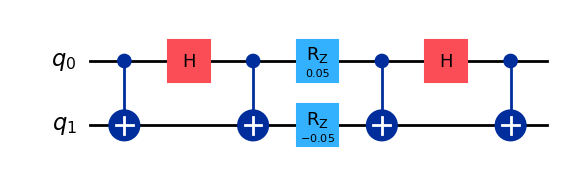

In [4]:
n_site=2
qr = QuantumRegister(n_site, "q")

### make main quantum circuit
qc = QuantumCircuit(qr)


a=1

dt=0.1
###exp(-iH_{XX+YY}\Delta t)
for i in range(n_site-1):
        qc.cx(qr[i],qr[i+1])
        qc.h(qr[i])
        qc.cx(qr[i],qr[i+1])

        qc.rz((0.5/a)*dt, qr[i])
        qc.rz(-(0.5/a)*dt, qr[i+1])

        qc.cx(qr[i],qr[i+1])
        qc.h(qr[i])
        qc.cx(qr[i],qr[i+1])
qc.draw("mpl")

In [5]:
def A(k):
    if k%2==0:
        return k/2        
    else:
        return -1*((k+1)/2)

In [14]:
def trotter(n_site, g ,M,t_max,step_max, pair):
    

    ########### as given in paper ###########
    #########################################

    J = 0.5*g*g*a

    # t_max = t_max  ### trotter parameters
    # step_max = step_max

    dt = t_max/step_max

    ### simulator and shots
    # simulator = Aer.get_backend('qasm_simulator')

    ### quantum registers
    qr = QuantumRegister(n_site)
    cr = ClassicalRegister(n_site)

    ### make main quantum circuit
    qc = QuantumCircuit(qr,cr)


    #######Prepapre Initial State#######
    from qiskit.quantum_info import random_statevector
    # from qiskit.tools.monitor import job_monitor


    ###make measurement circuit
    qc_meas = QuantumCircuit(qr,cr)
    #for q in qr:
    #    qc_meas.h(q)
    qc_meas.measure(qr,cr)

    time_list=[]
    total_Q_avg=[]
    cc_list=[]
    error_list=[]
    charge_dist =[]
    E_field_dist=[]

    num_density_list=[]
    num_density_list.append(0)
    time_list.append(0)
    charge_dist.append([0]*n_site)
    E_field_dist.append([0]*(n_site+1))
    total_Q_avg.append(0)
    cc_list.append(-0.5)




    job_counter=0
    n_shots = 10000

    # prepare the initial state
    for i in range(int(n_site/2)):
        qc.x(qr[2*i])


        ###############################################################################################################################
        ##################### Comment out this part to remove initial charges at the extremes #########################################
        if pair:
            qc.x(qr[0])                    
            qc.x(qr[-1])
            charge_dist[0][0]=   1
            charge_dist[0][-1]= -1
            E_field_dist[0][1:-1] = [1] * (n_site - 1)
            cc_list[0] = 2/n_site-0.5
            num_density_list[0] = 2/n_site
        ###############################################################################################################################


    for step in range(1,step_max+1):


        # gates to implement one Suzuki-Trotter step
        ###exp(-iH_{XX+YY}\Delta t) #even
        for i in range(n_site-1):
            qc.cx(qr[i],qr[i+1])
            qc.h(qr[i])
            qc.cx(qr[i],qr[i+1])

            qc.rz((0.5/a)*dt, qr[i])
            qc.rz(-(0.5/a)*dt, qr[i+1])

            qc.cx(qr[i],qr[i+1])
            qc.h(qr[i])
            qc.cx(qr[i],qr[i+1])


        
        ###  exp(-iH_{Z}\Delta t)   mass
        for i in range(n_site):
            qc.rz(M*((-1)**(i))*dt,qr[i])    




        ###  exp(-iH_{ZZ}\Delta t)  Electric Field
        for k in range(n_site):
            for l in range(k+1, n_site):
                # weight = N-1-l = n_site-1-l
                weight = n_site - 1 - l
                if weight != 0:
                    qc.rzz(J * weight * dt, qr[k], qr[l])


        ##  exp(-iH_{Z}\Delta t)  Electric Field
        for n in range(n_site-1):
            h1= 0.5*J*(n_site-1-n)*((-1)**n)
            h2= 0.5*J*((-1)**(n_site-1))*A(n_site-2-n)
            h3= 0.5*J*(n_site-1-n)* 0.5*(1- (-1)**n)
            qc.rz(2*(h1+h2+h3),qr[n])



        #add main circuit to measurement circuit to have total circuit
        qc_total = qc.compose(qc_meas)

        #execute circuit
        # job = execute(qc_total, simulator, shots=n_shots) #execute Simulator
        job = simulator.run(qc_total, shots=n_shots)
        print('About to run job')

        job.status()
        # job_monitor(job)
        job_counter+=1
        print("Processed",job_counter, "jobs:",100*job_counter/step_max,"% has been done")
        print("Time is",dt*step)

        result = job.result() # obtain results
        counts = result.get_counts(qc_total)

        #compute chiral condensate
        cc = 0
        num_density=0
        charges = [0]*n_site
        E_field = [0]

        se=0 #standard error

        error=[]
        for orig_bit_string, count in counts.items():
            obs = 0
            obs_2=0
            bit_string = orig_bit_string[::-1] 

            for j in range(n_site):
                obs +=(-1)**int(bit_string[j])*(-1)**(j)
            cc += obs*count/n_shots/(2*a)/n_site
            for k in range(n_site):
                obs_2+=  ( 1 + ((-1)**(k+int(bit_string[k]))))/2

            num_density +=(count/n_shots)* (obs_2/n_site)   



            for i in range(count):
                error.append(obs/(2*a))


        se=np.std(error)


        for orig_bit_string, count in counts.items():

            bit_string = orig_bit_string[::-1]
            for z in range(n_site):
                if z%2==0 and bit_string[z]=='0':
                    charges[z] += 1*count/n_shots
                elif z%2==1 and bit_string[z]=='1':    
                    charges[z] += -1*count/n_shots
            # print(charges)
        sum =0
        for z in range(n_site):
            sum+=charges[z]
            E_field.append(sum)
        






        total_Q_avg.append(E_field[-1])
        time_list.append(dt*step) #append time to the list of time
        E_field_dist.append(E_field)
        charge_dist.append(charges)
        cc_list.append(cc)
        num_density_list.append(num_density)
        error_list.append(se)


    return time_list,total_Q_avg,E_field_dist,charge_dist,num_density_list  





## Pair Production in Vaccuum 

About to run job
Processed 1 jobs: 10.0 % has been done
Time is 1.0
About to run job
Processed 2 jobs: 20.0 % has been done
Time is 2.0
About to run job
Processed 3 jobs: 30.0 % has been done
Time is 3.0
About to run job
Processed 4 jobs: 40.0 % has been done
Time is 4.0
About to run job
Processed 5 jobs: 50.0 % has been done
Time is 5.0
About to run job
Processed 6 jobs: 60.0 % has been done
Time is 6.0
About to run job
Processed 7 jobs: 70.0 % has been done
Time is 7.0
About to run job
Processed 8 jobs: 80.0 % has been done
Time is 8.0
About to run job
Processed 9 jobs: 90.0 % has been done
Time is 9.0
About to run job
Processed 10 jobs: 100.0 % has been done
Time is 10.0


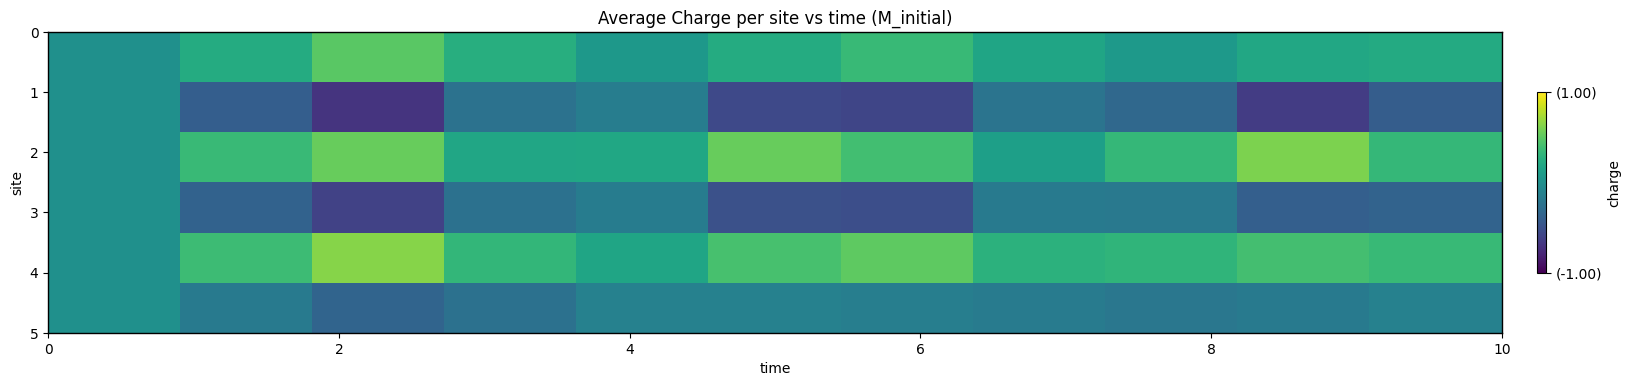

In [25]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

n_site=6
g=1.29
mass =0.083
n_steps = 10
t_max =10
time_list,total_Q_avg,E_field_dist,charge_dist,num_density_list = trotter(n_site,g,mass,t_max,n_steps,False)

# ---- Your data ----
Ax = np.array(charge_dist).T   # shape (n_site, n_time) or similar

fig, ax = plt.subplots(figsize=(18, 3.6))
im = ax.imshow(
    Ax,
    cmap='viridis',
    aspect='auto',
    vmin=-1, vmax=1,
    extent=[0, t_max, n_site - 1, 0]
)

# Y ticks
ax.set_yticks(np.arange(n_site))
ax.set_yticklabels([str(i) for i in range(0, n_site)])

# X ticks — set as you wish
# ax.set_xticks(np.round(np.arange(0, t_max, t_max/step_max),1))

# Frame
for spine in ax.spines.values():
    spine.set_linewidth(1)

# === Colorbar that labels vmin/vmax ===
cbar = fig.colorbar(im, ax=ax, pad=0.02, shrink=0.6, orientation='vertical')
vmin, vmax = im.get_clim()  # reads back (-1, 1) here
cbar.set_ticks([vmin, vmax])
cbar.set_ticklabels([f"({vmin:.2f})", f"({vmax:.2f})"])
cbar.set_label("charge", rotation=90)

plt.tight_layout()
plt.xlabel("time")
plt.ylabel("site")
plt.title("Average Charge per site vs time (M_initial)")
plt.show()


## Average Particle Number Density

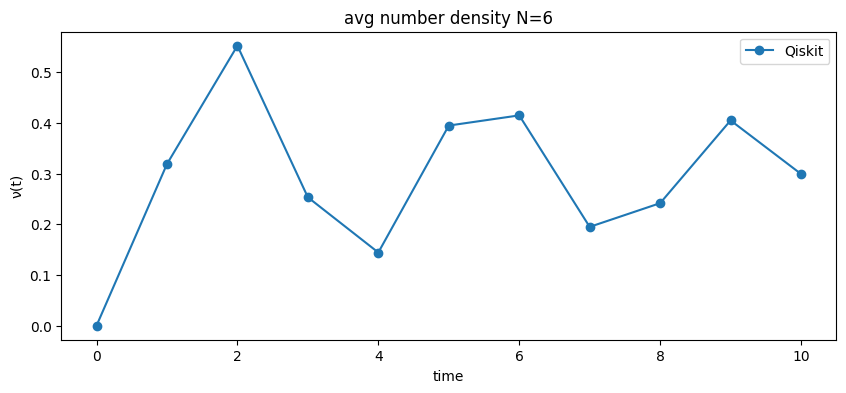

In [26]:
plt.figure(figsize=(10, 4))
plt.plot(time_list, num_density_list,marker='o',label='Qiskit')
plt.title('avg number density N=6')
plt.xlabel('time')
plt.ylabel('ν(t)')
# plt.ylim(0,0.5)
plt.legend()
plt.show()

## Toatl charge ( Sanity check shows charge conservation)

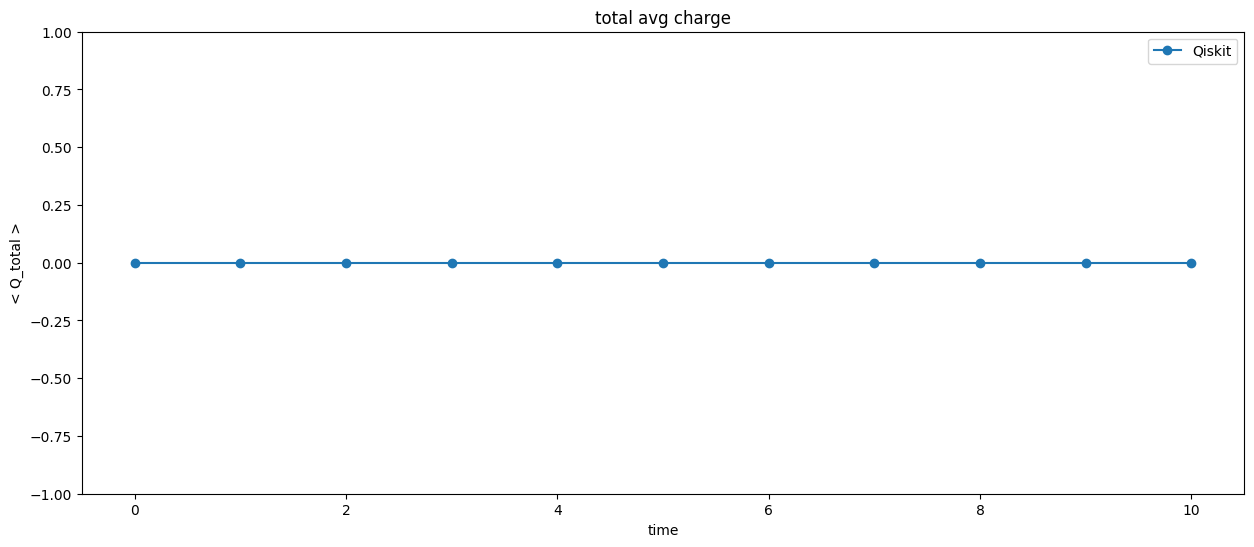

In [27]:
plt.figure(figsize=(15, 6))
plt.plot(time_list, total_Q_avg,marker='o',label='Qiskit')
plt.title('total avg charge')
plt.xlabel('time')
plt.ylabel("< Q_total >")
plt.ylim(-1,1)
plt.legend()
plt.show()

## String Breaking

We initialze the state with having a $e^+$ and a $e^-$ at the ends of the lattice and let the hamiltonian evolve

About to run job
Processed 1 jobs: 10.0 % has been done
Time is 1.0
About to run job
Processed 2 jobs: 20.0 % has been done
Time is 2.0
About to run job
Processed 3 jobs: 30.0 % has been done
Time is 3.0
About to run job
Processed 4 jobs: 40.0 % has been done
Time is 4.0
About to run job
Processed 5 jobs: 50.0 % has been done
Time is 5.0
About to run job
Processed 6 jobs: 60.0 % has been done
Time is 6.0
About to run job
Processed 7 jobs: 70.0 % has been done
Time is 7.0
About to run job
Processed 8 jobs: 80.0 % has been done
Time is 8.0
About to run job
Processed 9 jobs: 90.0 % has been done
Time is 9.0
About to run job
Processed 10 jobs: 100.0 % has been done
Time is 10.0


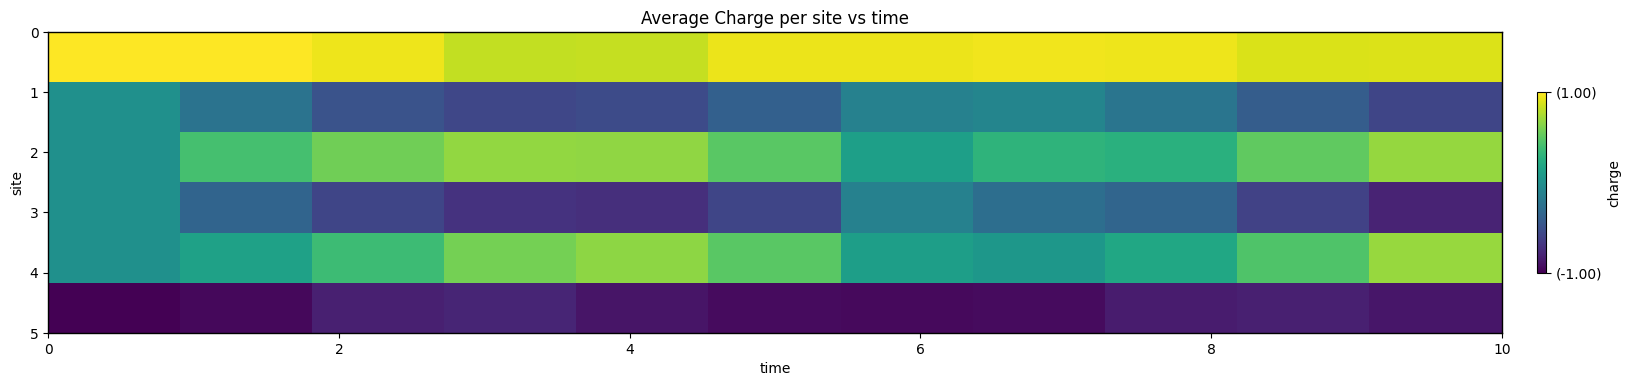

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

n_site=6
g=1.29
M=0.083
n_steps = 10
t_max =10
time_list,total_Q_avg,E_field_dist,charge_dist,num_density_list = trotter(n_site,g,M,t_max,n_steps,True)

# ---- Your data ----
Ax = np.array(charge_dist).T   # shape (n_site, n_time) or similar

fig, ax = plt.subplots(figsize=(18, 3.6))
im = ax.imshow(
    Ax,
    cmap='viridis',
    aspect='auto',
    vmin=-1, vmax=1,
    extent=[0, t_max, n_site - 1, 0]
)

# Y ticks
ax.set_yticks(np.arange(n_site))
ax.set_yticklabels([str(i) for i in range(0, n_site)])

# X ticks — set as you wish
# ax.set_xticks(np.round(np.arange(0, t_max, t_max/step_max),1))

# Frame
for spine in ax.spines.values():
    spine.set_linewidth(1)

# === Colorbar that labels vmin/vmax ===
cbar = fig.colorbar(im, ax=ax, pad=0.02, shrink=0.6, orientation='vertical')
vmin, vmax = im.get_clim()  # reads back (-1, 1) here
cbar.set_ticks([vmin, vmax])
cbar.set_ticklabels([f"({vmin:.2f})", f"({vmax:.2f})"])
cbar.set_label("charge", rotation=90)

plt.tight_layout()
plt.xlabel("time")
plt.ylabel("site")
plt.title("Average Charge per site vs time")
plt.show()


### Average Electric field (showing string breaking)

[-1, 0, 1, 2, 3, 4, 5]


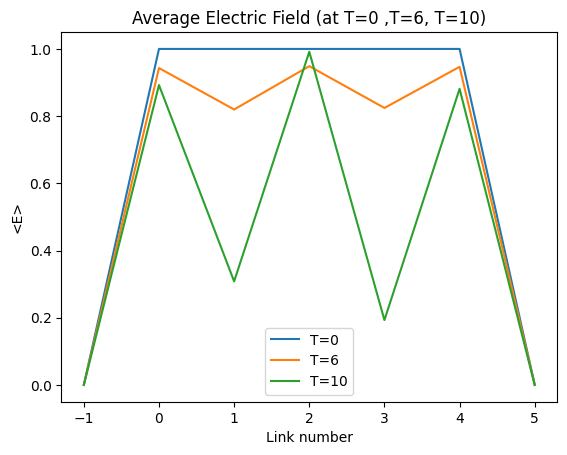

In [31]:
## this plot is for n =6 tmax=10 and with a fermion-antifermion pair at the ends
lst = list(range(-1, n_site))
print(lst)
plt.plot(lst, E_field_dist[0],label="T=0")
plt.plot(lst, E_field_dist[6],label="T=6")
plt.plot(lst, E_field_dist[10],label="T=10")
plt.xticks(lst) 
plt.title('Average Electric Field (at T=0 ,T=6, T=10)')
plt.xlabel('Link number')
plt.ylabel('<E>')
plt.legend()
plt.show()

### Suppresed String Breaking/pair production for High fermion mass

About to run job
Processed 1 jobs: 2.0 % has been done
Time is 0.2
About to run job
Processed 2 jobs: 4.0 % has been done
Time is 0.4
About to run job
Processed 3 jobs: 6.0 % has been done
Time is 0.6000000000000001
About to run job
Processed 4 jobs: 8.0 % has been done
Time is 0.8
About to run job
Processed 5 jobs: 10.0 % has been done
Time is 1.0
About to run job
Processed 6 jobs: 12.0 % has been done
Time is 1.2000000000000002
About to run job
Processed 7 jobs: 14.0 % has been done
Time is 1.4000000000000001
About to run job
Processed 8 jobs: 16.0 % has been done
Time is 1.6
About to run job
Processed 9 jobs: 18.0 % has been done
Time is 1.8
About to run job
Processed 10 jobs: 20.0 % has been done
Time is 2.0
About to run job
Processed 11 jobs: 22.0 % has been done
Time is 2.2
About to run job
Processed 12 jobs: 24.0 % has been done
Time is 2.4000000000000004
About to run job
Processed 13 jobs: 26.0 % has been done
Time is 2.6
About to run job
Processed 14 jobs: 28.0 % has been done

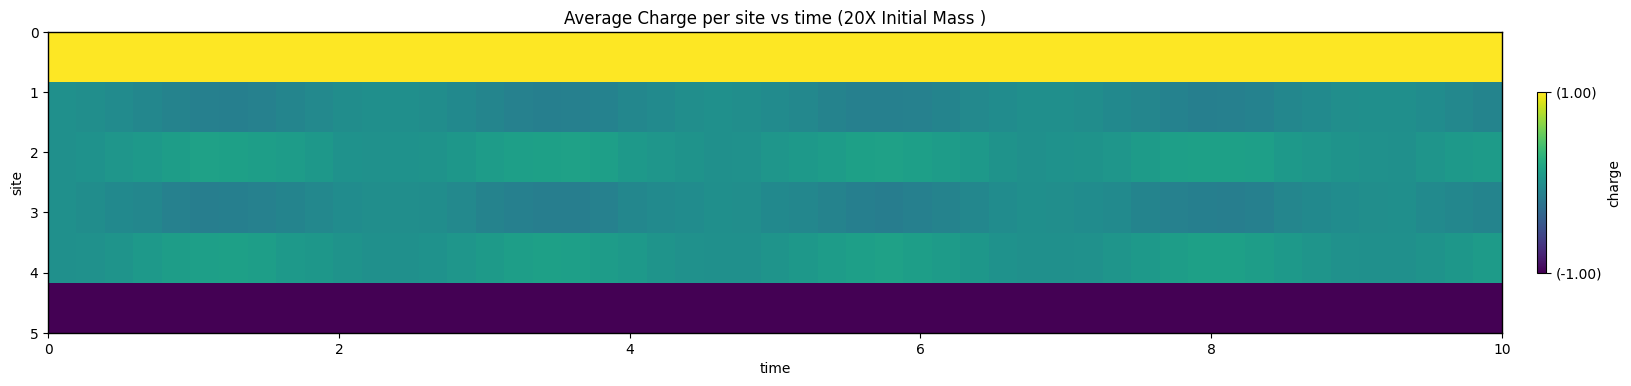

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

n_site=6
g=1.29
M=0.083 * 20  # 20x the initial mass taken
n_steps = 50   # we need high number of steps to see effect properly
t_max =10
time_list,total_Q_avg,E_field_dist,charge_dist,num_density_list = trotter(n_site,g,M,t_max,n_steps,True)

# ---- Your data ----
Ax = np.array(charge_dist).T   # shape (n_site, n_time) or similar

fig, ax = plt.subplots(figsize=(18, 3.6))
im = ax.imshow(
    Ax,
    cmap='viridis',
    aspect='auto',
    vmin=-1, vmax=1,
    extent=[0, t_max, n_site - 1, 0]
)

# Y ticks
ax.set_yticks(np.arange(n_site))
ax.set_yticklabels([str(i) for i in range(0, n_site)])

# X ticks — set as you wish
# ax.set_xticks(np.round(np.arange(0, t_max, t_max/step_max),1))

# Frame
for spine in ax.spines.values():
    spine.set_linewidth(1)

# === Colorbar that labels vmin/vmax ===
cbar = fig.colorbar(im, ax=ax, pad=0.02, shrink=0.6, orientation='vertical')
vmin, vmax = im.get_clim()  # reads back (-1, 1) here
cbar.set_ticks([vmin, vmax])
cbar.set_ticklabels([f"({vmin:.2f})", f"({vmax:.2f})"])
cbar.set_label("charge", rotation=90)

plt.tight_layout()
plt.xlabel("time")
plt.ylabel("site")
plt.title("Average Charge per site vs time (20X Initial Mass )")
plt.show()


# Comparison with Time Evolution using Exact Diaganalization 

Forr n_sites = 6

## Vaccuum Pair production (number density)

In [33]:

"""
Exact diagonalization + time evolution for N=4 Schwinger-model Hamiltonian
(theta=0, a=1). Computes & plots:
 - P_vac(t) = |<1010 | psi(t)>|^2
 - N_particles(t) = sum_i (1 + (-1)^i <Z_i(t)>) / 2
 - local <Z_i(t)>

Reference / uploaded image (if needed): /mnt/data/c0ce9d06-f701-4a8b-b953-7a33a5096996.png
"""

import numpy as np
import matplotlib.pyplot as plt
from numpy import kron
from scipy.linalg import eigh

# ------------------------
# Parameters (adjustable)
# -------------------------
def comparison(pair, m,trotter_steps):
    N = 6      # number of sites
    m = m   # mass parameter
    g2 = 1.29**2       # g^2
    g = 1.29
    trotter_steps = trotter_steps
    tmin, tmax = 0.0, 10.0
    n_tsteps = 400  # number of time points
    time_list,total_Q_avg,E_field_dist,charge_dist,num_density_list = trotter(N,g,m,tmax,trotter_steps,pair)

    # -------------------------
    # Pauli matrices & helper
    # -------------------------
    I = np.eye(2, dtype=complex)
    X = np.array([[0, 1], [1, 0]], dtype=complex)
    Y = np.array([[0, -1j], [1j, 0]], dtype=complex)
    Z = np.array([[1, 0], [0, -1]], dtype=complex)

    def op_on_site(single_site_op, site, N):
        """Return many-body operator with single_site_op on 'site' (0-indexed)."""
        ops = [I] * N
        ops[site] = single_site_op
        M = ops[0]
        for k in range(1, N):
            M = kron(M, ops[k])
        return M

    dim = 2**N

    # -------------------------
    # Build Hamiltonian pieces
    # -------------------------
    # 1) Kinetic XY-like term: (1/4) sum_{n=0}^{N-2} (X_n X_{n+1} + Y_n Y_{n+1})
    H_kin = np.zeros((dim, dim), dtype=complex)
    for n in range(N-1):
        H_kin += 0.25 * (op_on_site(X, n, N) @ op_on_site(X, n+1, N)
                        + op_on_site(Y, n, N) @ op_on_site(Y, n+1, N))

    # 2) Mass term: (m/2) sum_{n=0}^{N-1} (-1)^n Z_n
    H_mass = np.zeros((dim, dim), dtype=complex)
    for n in range(N):
        H_mass += (m / 2.0) * ((-1) ** n) * op_on_site(Z, n, N)

    # 3) Electric term: (g^2/2) sum_{n=0}^{N-2} L_n^2
    #    with Q_j = (Z_j + (-1)^j)/2, L_n = sum_{j=0}^n Q_j
    Q_ops = []
    for j in range(N):
        Q_ops.append(0.5 * (op_on_site(Z, j, N) + ((-1) ** j) * np.eye(dim, dtype=complex)))

    H_elec = np.zeros((dim, dim), dtype=complex)
    for n in range(N-1):
        L_n = np.zeros((dim, dim), dtype=complex)
        for j in range(n+1):
            L_n += Q_ops[j]
        H_elec += 0.5 * g2 * (L_n @ L_n)

    H = H_kin + H_mass + H_elec

    # -------------------------
    # Diagonalize H (exact)
    # -------------------------
    e_vals, e_vecs = eigh(H)  # eigenvalues ascending by default
    idx = np.argsort(e_vals)
    e_vals = e_vals[idx]
    e_vecs = e_vecs[:, idx]

    # -------------------------
    # Initial vacuum state |1 0 1 0>
    # -------------------------
    def basis_state_from_bits(bitlist):
        """Construct computational-basis vector for bitlist [q0, q1, ...]."""
        v = np.array([1.0 + 0j])
        for b in bitlist:
            if b == 0:
                v = kron(v, np.array([1.0, 0.0], dtype=complex))
            else:
                v = kron(v, np.array([0.0, 1.0], dtype=complex))
        return v

    if pair:
        psi_vac = basis_state_from_bits([0, 0, 1, 0,1,1])
    else:    
        psi_vac = basis_state_from_bits([1, 0, 1, 0,1,0])

    psi_vac /= np.linalg.norm(psi_vac)

    # Expand vacuum in eigenbasis: c_k = v_k^dagger |vac>
    coeffs = np.conjugate(e_vecs.T @ psi_vac)

    # Precompute Z operators for expectation values
    Z_ops = [op_on_site(Z, site, N) for site in range(N)]

    # -------------------------
    # Time evolution and observables
    # -------------------------
    tlist = np.linspace(tmin, tmax, n_tsteps)
    P_vac = np.zeros_like(tlist)
    N_particles = np.zeros_like(tlist)
    Z_expect = np.zeros((N, len(tlist)))

    for ti, t in enumerate(tlist):
        phases = np.exp(-1j * e_vals * t)        # e^{-i E_k t}
        psi_t = e_vecs @ (coeffs * phases)       # psi(t)
        P_vac[ti] = np.abs(np.vdot(psi_vac, psi_t))**2
        for site in range(N):
            Z_expect[site, ti] = np.vdot(psi_t, Z_ops[site] @ psi_t).real
        # corrected formula: sum_i (1 + (-1)^i * <Z_i(t)>) / 2
        signs = ((-1) ** np.arange(N))
        N_particles[ti] = np.sum((1.0 + signs * Z_expect[:, ti]) / (N*2.0))

    # -------------------------
    # Print some diagnostics
    # -------------------------
    print("Eigenvalues (energies):")
    for k, E in enumerate(e_vals):
        print(f"{k:2d}: {E:.8f}")
    print(f"\nGround state energy E0 = {e_vals[0]:.12f}")
    print(f"Initial overlap with ground state = {np.abs(np.vdot(e_vecs[:,0], psi_vac))**2:.12f}")



    # -------------------------
    # Plots: P_vac(t) and N_particles(t)
    # -------------------------
    plt.figure(figsize=(10,4))

    # plt.subplot(1,2,2)
    plt.plot(tlist, N_particles, lw=2,label= "Exact")
    plt.plot(time_list, num_density_list,marker='o',label='Qiskit')
    plt.xlim(0,t_max)
    plt.xlabel("time t")
    plt.ylabel(r"$N_{\mathrm{particles}}(t)$")
    plt.title("Average particle number (Exact vs Trotter)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()




About to run job
Processed 1 jobs: 6.666666666666667 % has been done
Time is 0.6666666666666666
About to run job
Processed 2 jobs: 13.333333333333334 % has been done
Time is 1.3333333333333333
About to run job
Processed 3 jobs: 20.0 % has been done
Time is 2.0
About to run job
Processed 4 jobs: 26.666666666666668 % has been done
Time is 2.6666666666666665
About to run job
Processed 5 jobs: 33.333333333333336 % has been done
Time is 3.333333333333333
About to run job
Processed 6 jobs: 40.0 % has been done
Time is 4.0
About to run job
Processed 7 jobs: 46.666666666666664 % has been done
Time is 4.666666666666666
About to run job
Processed 8 jobs: 53.333333333333336 % has been done
Time is 5.333333333333333
About to run job
Processed 9 jobs: 60.0 % has been done
Time is 6.0
About to run job
Processed 10 jobs: 66.66666666666667 % has been done
Time is 6.666666666666666
About to run job
Processed 11 jobs: 73.33333333333333 % has been done
Time is 7.333333333333333
About to run job
Processed

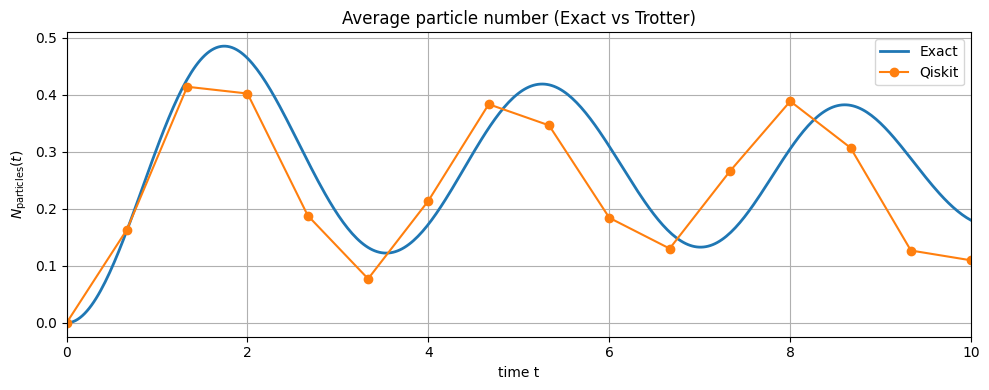

In [34]:
comparison(False,0.083,15)

## String Breaking (Low Mass)

About to run job
Processed 1 jobs: 6.666666666666667 % has been done
Time is 0.6666666666666666
About to run job
Processed 2 jobs: 13.333333333333334 % has been done
Time is 1.3333333333333333
About to run job
Processed 3 jobs: 20.0 % has been done
Time is 2.0
About to run job
Processed 4 jobs: 26.666666666666668 % has been done
Time is 2.6666666666666665
About to run job
Processed 5 jobs: 33.333333333333336 % has been done
Time is 3.333333333333333
About to run job
Processed 6 jobs: 40.0 % has been done
Time is 4.0
About to run job
Processed 7 jobs: 46.666666666666664 % has been done
Time is 4.666666666666666
About to run job
Processed 8 jobs: 53.333333333333336 % has been done
Time is 5.333333333333333
About to run job
Processed 9 jobs: 60.0 % has been done
Time is 6.0
About to run job
Processed 10 jobs: 66.66666666666667 % has been done
Time is 6.666666666666666
About to run job
Processed 11 jobs: 73.33333333333333 % has been done
Time is 7.333333333333333
About to run job
Processed

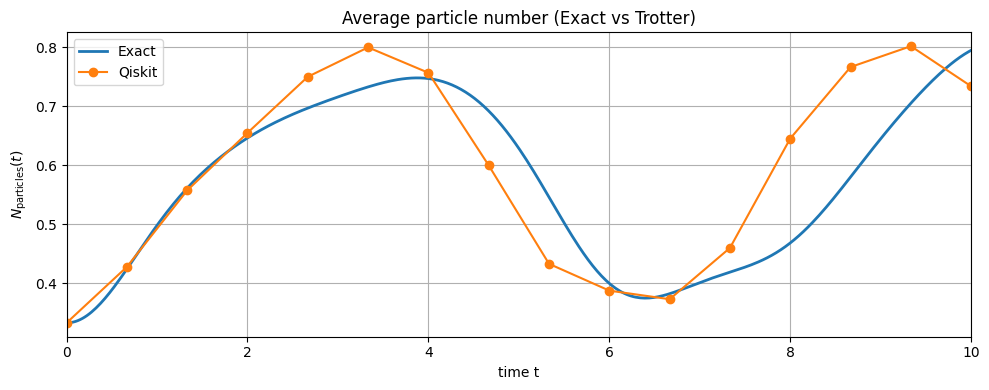

In [35]:
comparison(True,0.083,15)

## String Breaking (High Mass)

About to run job
Processed 1 jobs: 2.0 % has been done
Time is 0.2
About to run job
Processed 2 jobs: 4.0 % has been done
Time is 0.4
About to run job
Processed 3 jobs: 6.0 % has been done
Time is 0.6000000000000001
About to run job
Processed 4 jobs: 8.0 % has been done
Time is 0.8
About to run job
Processed 5 jobs: 10.0 % has been done
Time is 1.0
About to run job
Processed 6 jobs: 12.0 % has been done
Time is 1.2000000000000002
About to run job
Processed 7 jobs: 14.0 % has been done
Time is 1.4000000000000001
About to run job
Processed 8 jobs: 16.0 % has been done
Time is 1.6
About to run job
Processed 9 jobs: 18.0 % has been done
Time is 1.8
About to run job
Processed 10 jobs: 20.0 % has been done
Time is 2.0
About to run job
Processed 11 jobs: 22.0 % has been done
Time is 2.2
About to run job
Processed 12 jobs: 24.0 % has been done
Time is 2.4000000000000004
About to run job
Processed 13 jobs: 26.0 % has been done
Time is 2.6
About to run job
Processed 14 jobs: 28.0 % has been done

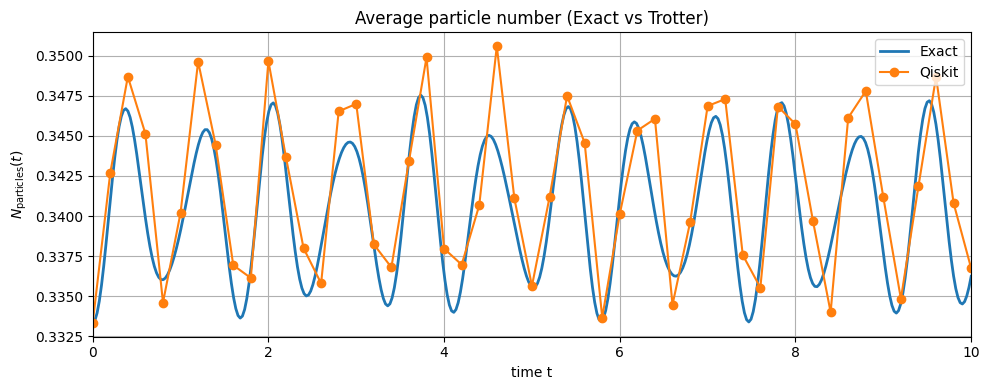

In [87]:
comparison(True,0.083*50, 50)

We see the average density hovers around 1/3 i.e 2 particles per 6 sites. This infers no new particles tend to be created

# Simulation of phase transition

Now we demonstarete interesting physics of the massive Schwinger model.
Remember the phase diagram.



Using the previous data of the adiabatic state preparation, we can demonstrate the phase transition.

Our time-dependent Hamiltonian is
\begin{align}
\begin{aligned}
H(t)=&\sum_{n=1}^{N-1}
    \left(\frac{1}{4a}-\frac{m}{4}(-1)^n\sin(2\pi t)\right)
    \left(X_n X_{n+1}+Y_n Y_{n+1}\right)\\
&+\sum_{n=1}^{N}\frac{m(-1)^n\cos(2\pi t)}{2} Z_n+\frac{ag^2}{2}\sum_{n=0}^{N}L^2_n.
\end{aligned}
\end{align}

We should still keep the ground state of the Hamiltonian at $m$, if we did not destroy the circuit above. (Please execute adiabatic state preparation now if you have not done yet.)

Now let us gradually change the $\theta$-term from 0 to $2\pi$. Then according to the phase diagram, there should be a (first-order or second-order) phase transition at $\theta=\pi$.

In [ ]:
### parameters
n_site = 8
a = 1
M=3
g=1


J = 0.5*g*g*a

t_max = 1
step_max = 50

dt = t_max/step_max

### quantum registers
qr = QuantumRegister(n_site)
cr = ClassicalRegister(n_site)

### make main quantum circuit
qc = QuantumCircuit(qr,cr)


#######Prepapre Initial State#######

###make measurement circuit
qc_meas = QuantumCircuit(qr,cr)
#for q in qr:
#    qc_meas.h(q)
qc_meas.measure(qr,cr)

time_list=[]
cc_list=[]
error_list=[]



job_counter=0
n_shots = 10000

## prepare the initial state
for i in range(int(n_site/2)):
  qc.x(qr[2*i])
time_list2=[]
cc_list2=[]
error_list2=[]


for step in range(1,step_max+1):
    #acting gates to implement one Suzuki-Trotter step
    ###exp(-iH_{XX+YY}\Delta t) 2nd order Suzuki-Trotter decomposition
    for i in range(n_site-1):
        qc.cx(qr[i],qr[i+1])
        qc.h(qr[i])
        qc.cx(qr[i],qr[i+1])

        qc.rz(0.5*((0.5/a)-0.5*np.sin(2*np.pi*step*dt)*M*(-1)**(i+1))*dt, qr[i])
        qc.rz(-0.5*((0.5/a)-0.5*np.sin(2*np.pi*step*dt)*M*(-1)**(i+1))*dt, qr[i+1])

        qc.cx(qr[i],qr[i+1])
        qc.h(qr[i])
        qc.cx(qr[i],qr[i+1])

    ###exp(-iH_{Z}\Delta t)   mass
    for i in range(n_site):
        qc.rz(M*((-1)**(i+1))*np.cos(2*step*np.pi*dt)*dt,qr[i])


    ###exp(-iH_{ZZ}\Delta t)  Electric Field
    for k in range(n_site):
        for l in range(k+1, n_site):
            # weight = N-1-l = n_site-1-l
            weight = n_site - 1 - l
            if weight != 0:
                qc.rzz(J * weight * dt, qr[k], qr[l])

    #     ###exp(-iH_{Z}\Delta t)  Electric Field
    for n in range(n_site-1):
        qc.rz(-0.5*J*dt*(n_site-(n+1)-0.5*(-1+(-1)**(n+1))),qr[n])

    #2nd order Suzuki-Trotter decomposition
    for i in range(n_site-1):
        qc.cx(qr[i],qr[i+1])
        qc.h(qr[i])
        qc.cx(qr[i],qr[i+1])

        qc.rz(0.5*((0.5/a)-0.5*np.sin(2*np.pi*step*dt)*M*(-1)**(i+1))*dt, qr[i])
        qc.rz(-0.5*((0.5/a)-0.5*np.sin(2*np.pi*step*dt)*M*(-1)**(i+1))*dt, qr[i+1])

        qc.cx(qr[i],qr[i+1])
        qc.h(qr[i])
        qc.cx(qr[i],qr[i+1])



    #add main circuit to measurement circuit to have total circuit
    qc_total = qc.compose(qc_meas)

    #execute circuit
    # job = execute(qc_total, simulator, shots=n_shots) #execute Simulator
    job = simulator.run(qc_total, shots=n_shots)
    print('About to run job')

    job.status()
    # job_monitor(job)
    job_counter+=1
    print("Processed",job_counter, "jobs:",100*job_counter/step_max,"% has been done")
    print("Time is",dt*step)

    result = job.result() # obtain results
    counts = result.get_counts(qc_total)

    cc = 0
    for orig_bit_string, count in counts.items():

        obs = 0
        bit_string = orig_bit_string[::-1]
        for j in range(n_site):
            obs +=(-1)**int(bit_string[j])*(-1)**(j)
        cc += obs*count/n_shots/(2*a)/n_site





    time_list2.append(dt*step) #append time to the list of time
    cc_list2.append(cc)

About to run job
Processed 1 jobs: 2.0 % has been done
Time is 0.02
About to run job
Processed 2 jobs: 4.0 % has been done
Time is 0.04
About to run job
Processed 3 jobs: 6.0 % has been done
Time is 0.06
About to run job
Processed 4 jobs: 8.0 % has been done
Time is 0.08
About to run job
Processed 5 jobs: 10.0 % has been done
Time is 0.1
About to run job
Processed 6 jobs: 12.0 % has been done
Time is 0.12
About to run job
Processed 7 jobs: 14.0 % has been done
Time is 0.14
About to run job
Processed 8 jobs: 16.0 % has been done
Time is 0.16
About to run job
Processed 9 jobs: 18.0 % has been done
Time is 0.18
About to run job
Processed 10 jobs: 20.0 % has been done
Time is 0.2
About to run job
Processed 11 jobs: 22.0 % has been done
Time is 0.22
About to run job
Processed 12 jobs: 24.0 % has been done
Time is 0.24
About to run job
Processed 13 jobs: 26.0 % has been done
Time is 0.26
About to run job
Processed 14 jobs: 28.0 % has been done
Time is 0.28
About to run job
Processed 15 jobs:

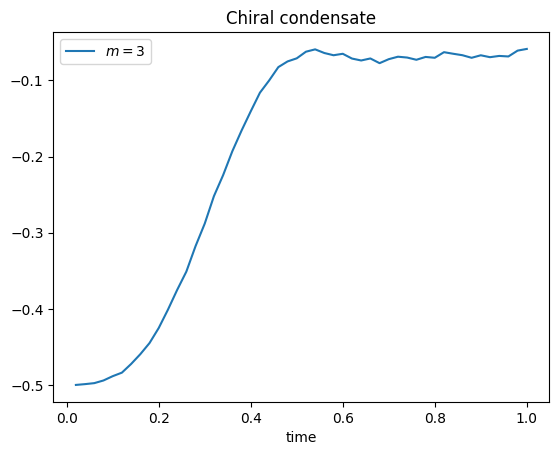

In [115]:
plt.plot(time_list2, cc_list2, "-",label=f'$m={M}$')
plt.title('Chiral condensate')
plt.xlabel("time")
plt.legend()
plt.show()

The sudden change in chiral condesate starts at around $t=0.5$ corresponds to the critical point of the phase transition.